In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, sys
import skimage.io
import pickle
import itertools
import random

from keras.models import Model, load_model, model_from_json
from keras.layers import Input, BatchNormalization
from keras.layers.core import Dropout, Flatten, Dense, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras import optimizers
from keras.utils import to_categorical, plot_model
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import EarlyStopping
from IPython.display import SVG

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc

import imgaug as ia
from imgaug import augmenters as iaa

sys.path.append(r'C:\Users\nimro\Documents\Python Scripts')
import img_utils

%matplotlib inline

# Paths and Constants

In [3]:
IMG_WIDTH = 28
IMG_HEIGHT = 28
IMG_CHANNELS = 1
NUM_CLASSES = 10
IMG_PATH = r'C:\Users\nimro\Documents\Data\FashionMnist'
LBL_PATH = r'C:\Users\nimro\Documents\Data\FashionMnist'

# Load and organize the data

In [4]:
"""read csv to numpy arrays"""
dfTrain = pd.read_csv(os.path.join(IMG_PATH, 'fashion-mnist_train.csv'))
dfTest = pd.read_csv(os.path.join(IMG_PATH, 'fashion-mnist_test.csv'))

rawTrainLabels = dfTrain.as_matrix(columns=dfTrain.columns[0:1])
rawTestLabels = dfTest.as_matrix(columns=dfTest.columns[0:1])
Y_train = to_categorical(rawTrainLabels)
Y_test = to_categorical(rawTestLabels)

X_train = dfTrain.as_matrix(columns=dfTrain.columns[1:]).astype(np.uint8)
X_train = X_train.reshape(-1, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)
X_test = dfTest.as_matrix(columns=dfTrain.columns[1:])
X_test = X_test.reshape(-1, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

X_train_after_split, X_val, Y_train_after_split, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42)

_, _, Y_train_after_split_cls, _ = train_test_split(
    X_train, rawTrainLabels, test_size=0.2, random_state=42)

# Classes handling
originalClasses = {
    0: 'T-Shirt \ Top', 
    1: 'Trouser', 
    2: 'Pullover', 
    3: 'Dress', 
    4: 'Coat',
    5: 'Sandal', 
    6: 'Shirt', 
    7: 'Sneaker', 
    8: 'Bag', 
    9: 'Ankle boot'
}

# Data Exploration
### Notes
* Data is balanced(train and test)
* Some classes have high resemblance: coat - pullover, ankle boot-sneaker, shirt-T-shirt\top

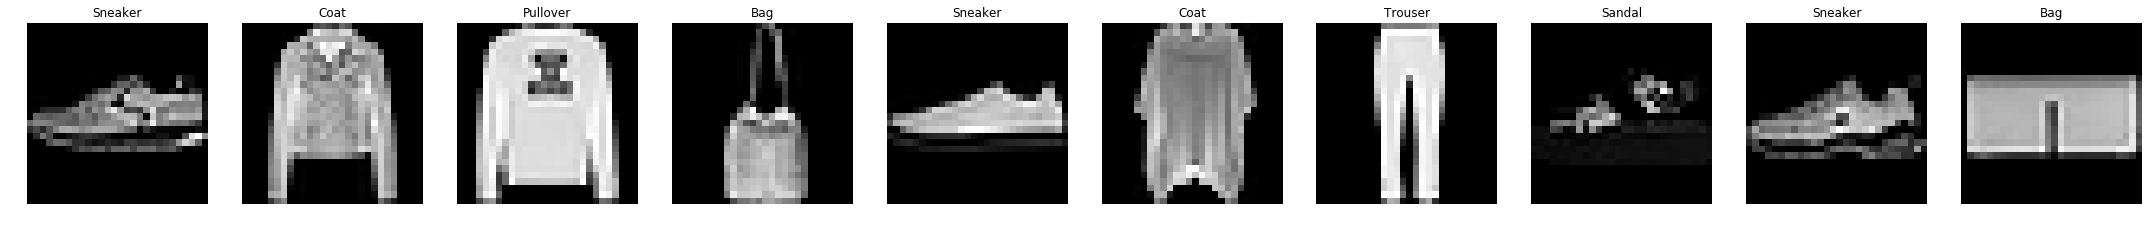

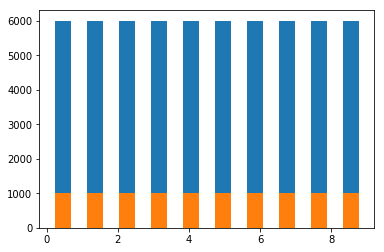

In [12]:
listOfImgs = img_utils.showRandomDataFromArrayWithLabels(X_train, numOfFigs=10, labels=originalClasses, cls=rawTrainLabels)
plt.hist(rawTrainLabels, bins=10, range=(0,9), rwidth=0.5)
plt.hist(rawTestLabels, rwidth=0.5)
plt.show()

# CNN Model

In [13]:
def createModel(dropRate=0.5, plot=True):
    inputs = Input(shape=(X_train.shape[1:]))
    s = Lambda(lambda x: x / 255) (inputs)
    conv1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    pool1 = MaxPooling2D((2,2))(conv1)

    conv2 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    pool2 = MaxPooling2D((2,2))(conv2)

    conv3 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    pool3 = MaxPooling2D((2,2))(conv3)

    x = Flatten()(pool3)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropRate)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=[inputs], outputs=[outputs])
    modelAug = Model(inputs=[inputs], outputs=[outputs])

    Optimizer = optimizers.adam()
    model.compile(optimizer=Optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    if plot:
        model.summary()
        SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
        
    return model

# Data Pre-processing
### Notes
All images are from same view, possible augemntations:
* flip left-right
* translation
* rotation
* affine transformations

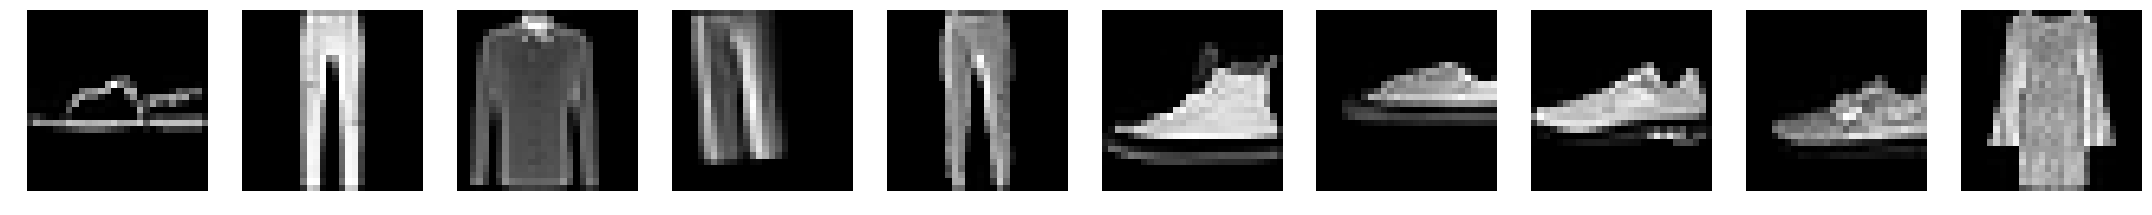

In [18]:
# Data Augmentation
augmentedImgs = np.zeros((len(X_train_after_split), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
augmentedLabels = np.zeros((Y_train_after_split.shape), dtype=np.float32)

seq = iaa.Sequential(
[
    iaa.SomeOf((0,2),
   [
    iaa.Affine( translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, deterministic=True),
    iaa.Fliplr(0.5),
    iaa.Affine( rotate=(-20, 20), deterministic=True)    
   ])
], random_order=True)

seq_det = seq.to_deterministic()
augmentedImgs = seq_det.augment_images(X_train_after_split)
augmentedLabels = np.copy(Y_train_after_split)

listOfAugm = img_utils.showRandomDataFromArrayWithLabels(augmentedImgs)

# combine train images and augmented images
# Size of train set is doubled (after train-validation split)
X_train_splited_augmented = np.concatenate((X_train_after_split, augmentedImgs), axis=0)
Y_train_splited_augmented = np.concatenate((Y_train_after_split, augmentedLabels), axis=0)

# Training Phase

In [19]:
callbacks = [EarlyStopping(patience=5, verbose=1)]
epochsNum = 10
batchSize = 32
# Consider perform random search on LR and Dropout rate

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        9280      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 64)          36928     
__________

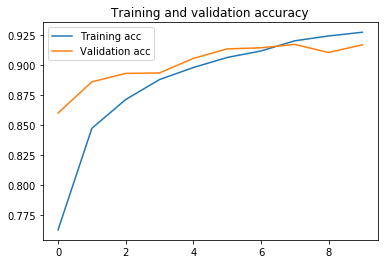

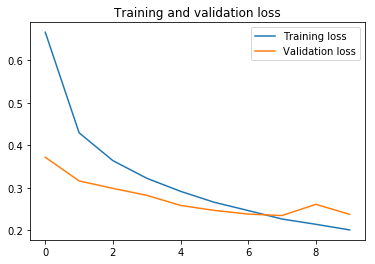

In [20]:
# Train model - Naive
model = createModel()
history = model.fit(X_train_after_split, Y_train_after_split, validation_data=(X_val, Y_val), batch_size=batchSize, 
                    epochs=epochsNum, callbacks=callbacks)

model_json = model.to_json()
with open("FashiomMNIST0.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("FashiomMNIST0.h5")
print("Saved model to disk")

with open('FashiomMNIST0_hisotry', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)    
    
# summarize history for loss and accuracy
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(acc, label='Training acc')
plt.plot(val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        9280      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 64)          36928     
__________

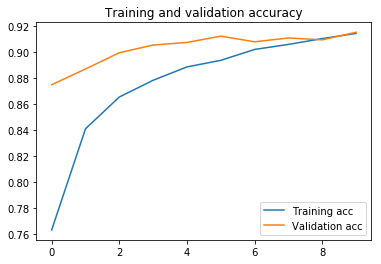

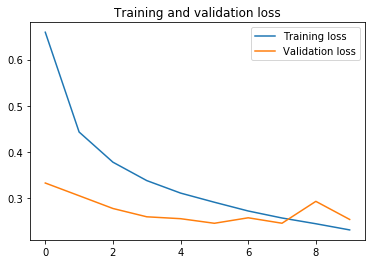

In [22]:
# Train model - With Augmentations
modelAug = createModel()
historyAug = modelAug.fit(X_train_splited_augmented, Y_train_splited_augmented, validation_data=(X_val, Y_val), 
                    batch_size=batchSize, epochs=epochsNum, callbacks=callbacks)

model_json = model.to_json()
with open("FashiomMNIST0Augm.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("FashiomMNIST0Augm.h5")
print("Saved model to disk")

with open('FashiomMNIST0Augm_hisotry', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)    
    
    
# summarize history for loss and accuracy
acc = historyAug.history['acc']
val_acc = historyAug.history['val_acc']
loss = historyAug.history['loss']
val_loss = historyAug.history['val_loss']
plt.plot(acc, label='Training acc')
plt.plot(val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [23]:
Y_pred = model.predict(X_test)
Y_predClasses = np.argmax(Y_pred, axis =1)
Y_predClasses = Y_predClasses.reshape(rawTestLabels.shape)

score = model.evaluate(x=X_test, y=Y_test)
print(score)

10000/10000 [==============================] - 5s 478us/step
[0.23548425462841988, 0.9173]


In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
    else:
#         print('Confusion matrix, without normalization')
        pass
#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Prediction Analysis

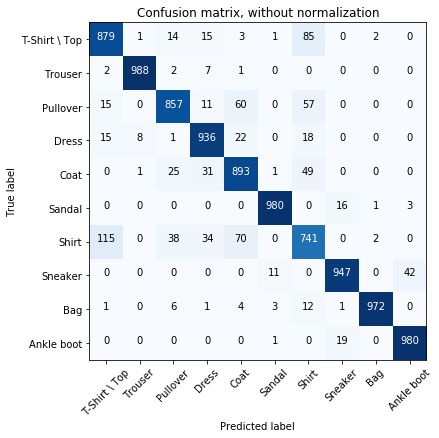

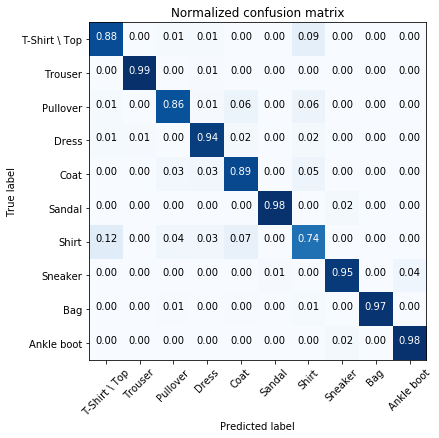

In [25]:
classNames = originalClasses.values()
# Compute confusion matrix
cnf_matrix = confusion_matrix(rawTestLabels, Y_predClasses)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=classNames,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=classNames, normalize=True,
                      title='Normalized confusion matrix')

As suspected:
Similar classes:
* Shirt - T-Shirt \ Top
* Pullover - Coat or Pulover - shirt
* Sneaker - Ankle boot

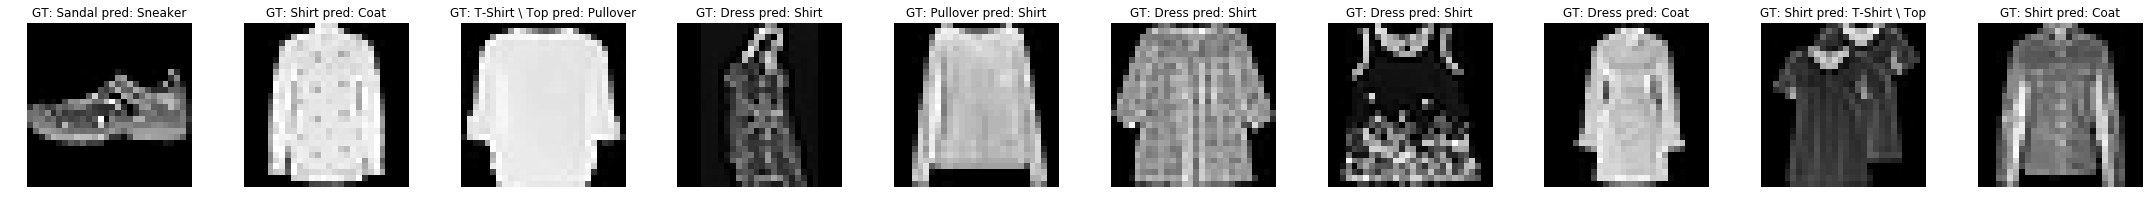

In [26]:
"""Wrong Classsifications"""
wrongCond = Y_predClasses != rawTestLabels
wrongCond = wrongCond.reshape(len(wrongCond))
wrongPredictions = Y_predClasses[wrongCond]
wrongPredictionsData = X_test[wrongCond, :, :]
wrongInds = np.where(wrongCond == True)

fig, axes = plt.subplots(1, 10, figsize=(30, 10))
for i in range(0, 10):
    index = np.random.choice(wrongInds[0])
    axes[i].imshow(X_test[index, :, :, 0], cmap='gray')
    axes[i].axis('off')
    gtStr = 'GT: ' + originalClasses[int(rawTestLabels[index])]
    predStr = 'pred: ' + originalClasses[int(Y_predClasses[index])]
    titleStr = gtStr + " " + predStr
    axes[i].set_title(titleStr)
        

plt.tight_layout()
plt.show()

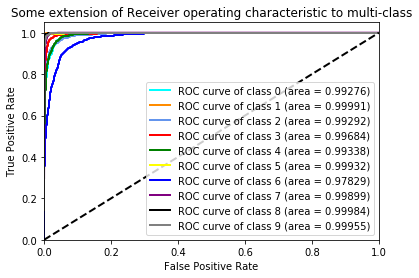

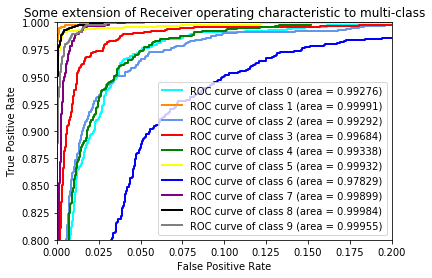

In [27]:
lw = 2

colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue', 'red',
                          'green', 'yellow', 'blue', 'purple', 'black', 'grey'])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
ROCAUC = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], Y_pred[:, i])
    ROCAUC[i] = auc(fpr[i], tpr[i])
    
# Plot all ROC curves
plt.figure(1)

for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.5f})'
             ''.format(i, ROCAUC[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)

for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.5f})'
             ''.format(i, ROCAUC[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

Can see that the worse ROC curve is for class 6 which is Shirt.
<br>Confusion matrix emphesize the different between the classes.